In [1]:
from Neuron_analysis_tool.Analyzer import Analyzer, long_pulse_protocol
from Neuron_analysis_tool.utils import video_player
from pathlib import Path
from neuron import gui, h
import numpy as np
import os
import matplotlib.pyplot as plt

NEURON mechanisms not found in /ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/x86_64/special.


NEURON: unable to open font "*helvetica-medium-r-normal*--14*", using "fixed"


## loading cell from ASC file format

In [2]:

dir_path = os.path.abspath('')
morph_path=os.path.join(dir_path,'data/morph2.ASC')

analyser = Analyzer(type='ASC', morph_path=morph_path, Rm=149994.0, Ra=300.0, Cm=0.7, seg_every=100)



19277 lines read

/ems/elsc-labs/segev-i/yoni.leibner/PycharmProjects/Neuron_analysis_tool/Neuron_analysis_tool/data/morph2.ASC problems


Main branch starting at line 303 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma

Main branch starting at line 701 is outside the soma bounding boxes
  Making a logical connection to center of nearest soma


## plot the cell morphology

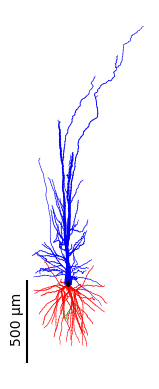

In [3]:
_,_,_=analyser.plot_morph(scale=500, diam_factor=0.5, theta=10)

## create a somaticentric view card 

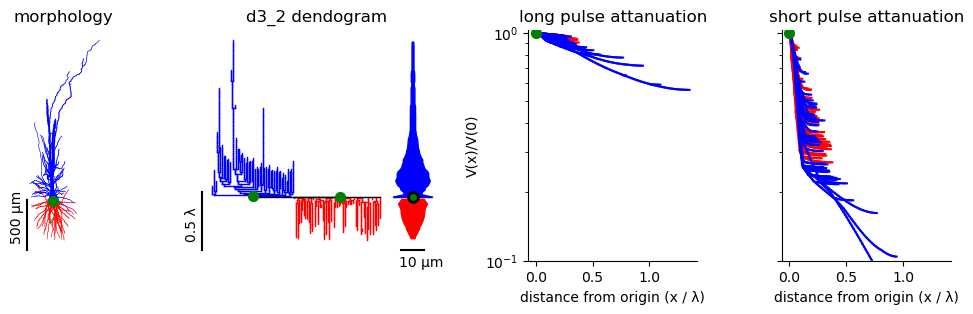

In [4]:
fig, ax = analyser.create_card(theta=10, diam_factor=0.5, cable_factor=3)

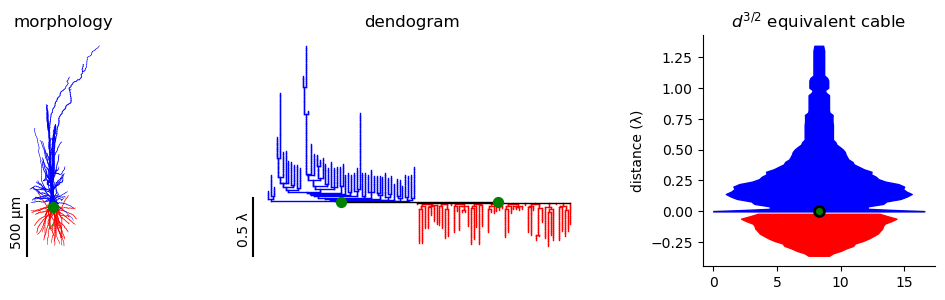

In [5]:
fig, ax = analyser.create_morpho_card(theta=10, diam_factor=0.5)

## create a spasific segment centric view card

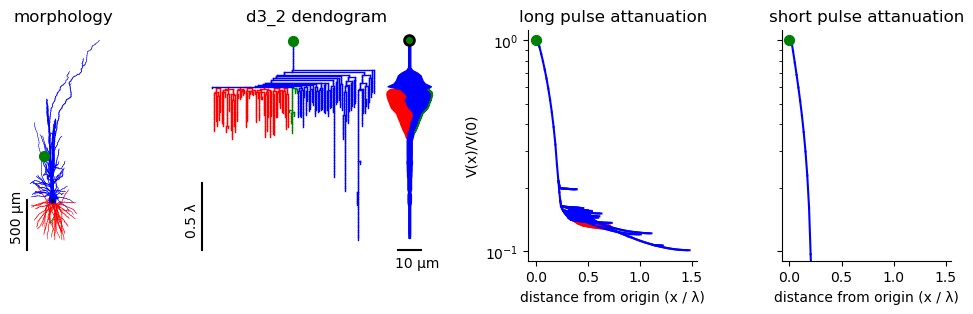

In [6]:
fig, ax = analyser.create_card(start_seg=list(analyser.cell.apic[59])[-1], theta=10, diam_factor=0.5, cable_factor=3)

## defining a seg value function and flot the result on the cell morphology

#### here we show that the the elongation of terminal branchecs create center seround kernel, where in the center we have cble that are couple to the main load of a neuron and in the seround we have an electrical isolation from the load

Text(0.5, 1.0, 'Rin at half max =0.55')

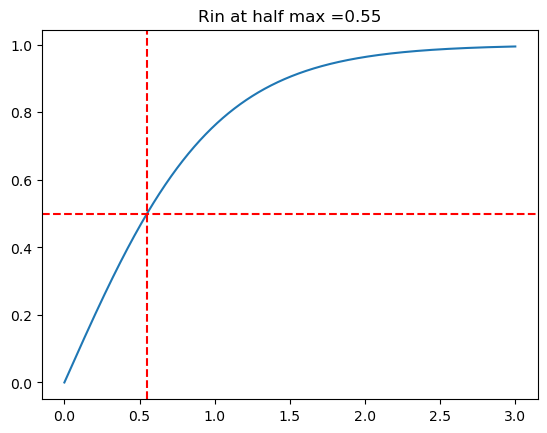

In [7]:
# in the passive case Rin of this cables can be simplified to a ball and stick such that:
# Rin = R_inf * (R_inf+R_l*tanh(L))/(R_l+R_inf*tanh(L)) 
# with R_inf the input resistance of semi infinate cable with the start diameter and R_l as the input resistance of the load
def Rin_load(L, R_l=100, R_inf=1000):
    return R_inf*(R_l+R_inf*np.tanh(L))/(R_inf+R_l*np.tanh(L))
L = np.arange(0, 3, 0.001)
Rin_load_=Rin_load(L, R_l=0.0, R_inf=1)
plt.plot(L, Rin_load_)
plt.axvline(L[Rin_load_>0.5][0], color='r', ls='--')
plt.axhline(0.5, color='r', ls='--')
plt.title('Rin at half max ='+str(L[Rin_load_>0.5][0]))

In [8]:
def cable_threshold(seg, min_d_for_load = 10, factor_e_space=100):
    cable_parent, cable_sons = analyser.get_cable(start_seg=seg, factor_e_space=factor_e_space)
    lamda_dist = np.arange(0, len(cable_sons), 1)*1.0/factor_e_space
    total_cable = cable_parent+cable_sons
    return lamda_dist[total_cable>min_d_for_load][0]
    

axon: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  6.05it/s]
else: 0it [00:00, ?it/s]


Text(0, 0.5, 'decaple distance to the load (λ)')

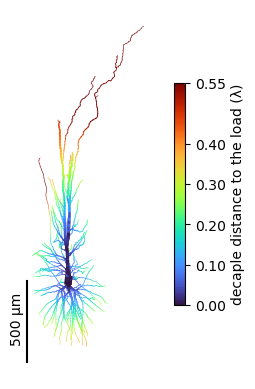

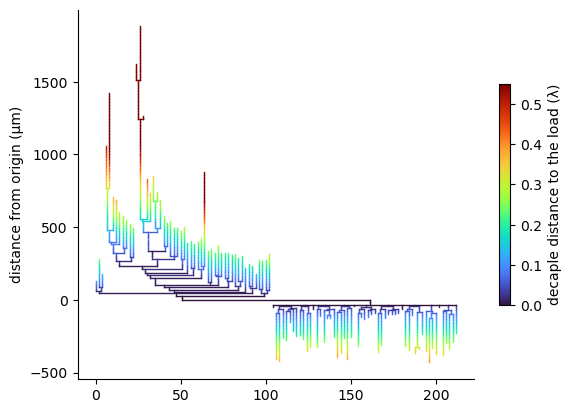

In [9]:

ax, color_bar, colors, lines, segs=analyser.plot_morph_with_value_func(func = cable_threshold, 
                                                                       run_time=0, theta=10, 
                                                                       scale=500, diam_factor=0.5, 
                                                                       bounds=[0, 0.55])#, colors=colors)
color_bar.set_ylabel('decaple distance to the load (\u03BB)')


plt.figure()
ax, x_pos, cax, colors, lines, segs = analyser.plot_dendogram_with_value_func(func = None, diam_factor=None, 
                                                                              colors=colors, electrical=False)
cax.set_ylabel('decaple distance to the load (\u03BB)')


#### here we show that the first bifurcation in the apical tree impose a frequncy gating for signal passing to the relative hot spot
#### we start by difining a function that gives the transfer impadance between 2 segments and then calculating it for all the segments with respect to the hot spot (1/2/3), the hot spot position is marked by a red circle

In [7]:
# hot_spots = [list(analyser.cell.apic[43])[-1], list(analyser.cell.apic[64])[-1], list(analyser.cell.apic[77])[-1]]

hot_spots1 = [analyser.cell.apic[93](0.976251), analyser.cell.apic[74](0.442795)]
hot_spots = []
for seg in hot_spots1:
    for seg2 in seg.sec:
        if seg2==seg:
            hot_spots.append(seg2)
            
# hot_spots = [list(analyser.cell.apic[93])[-1], list(analyser.cell.apic[74])[-1]]

freqs = np.concatenate([np.arange(0, 1, 0.05), np.arange(1, 10, 0.1), np.arange(10, 1000,1)])
def transfer_freq(seg1, seg2, freqs = freqs):
    imp = h.Impedance(seg1.x, sec=seg1.sec)
    imp.loc(seg1.x, sec=seg1.sec)
    transfer = []
    for freq in freqs:
        imp.compute(freq)
        transfer.append(imp.transfer(seg2.x, sec=seg2.sec))
    return freqs, np.array(transfer)


axon: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.21it/s]
else: 0it [00:00, ?it/s]


Text(0, 0.5, 'f_half (Hz)')

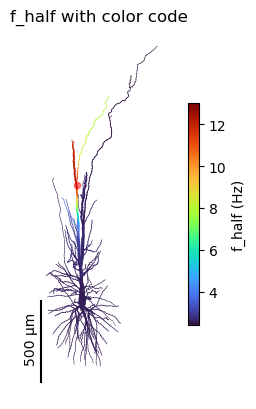

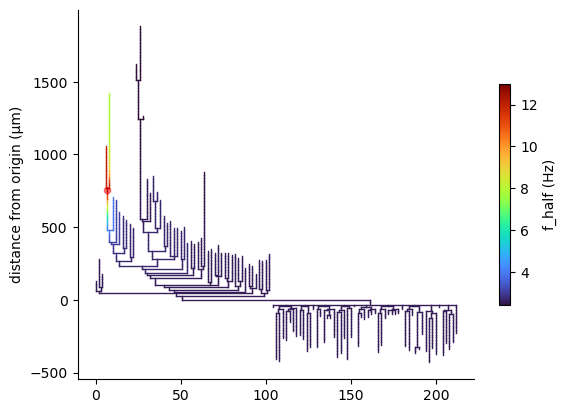

In [8]:

def f_half(seg):
    f, R_tr = transfer_freq(seg, hot_spots[0])
    f_half = f[R_tr<(R_tr.max()-R_tr.min())/2][0]
    return f_half

seg_to_indicate_dict={hot_spots[0]:dict(color='r', alpha=0.5, size=20)}
plt.title('f_half with color code')
ax, color_bar, colors, lines, segs=analyser.plot_morph_with_value_func(func = f_half, run_time=1000, theta=10, 
                                                                       scale=500, diam_factor=0.5, 
                                                                       seg_to_indicate_dict=seg_to_indicate_dict)#, colors=colors)
color_bar.set_ylabel('f_half (Hz)')

plt.figure()
ax, x_pos, cax, colors, lines, segs = analyser.plot_dendogram_with_value_func(func = None, diam_factor=None, colors=colors, 
                                                                 segs_to_indecate=seg_to_indicate_dict)
cax.set_ylabel('f_half (Hz)')


axon: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 10.78it/s]
else: 0it [00:00, ?it/s]


Text(0, 0.5, 'f_half (Hz)')

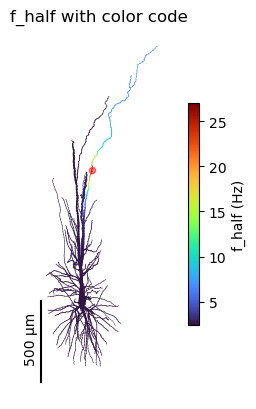

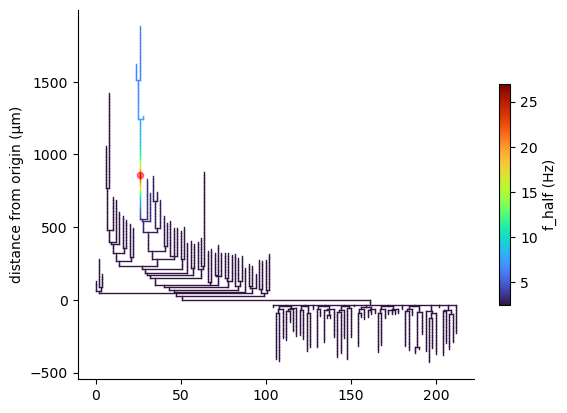

In [9]:
def f_half(seg):
    f, R_tr = transfer_freq(seg, hot_spots[1])
    f_half = f[R_tr<(R_tr.max()-R_tr.min())/2][0]
    return f_half

seg_to_indicate_dict={hot_spots[1]:dict(color='r', alpha=0.5, size=20)}
plt.title('f_half with color code')
ax, color_bar, colors, lines, segs=analyser.plot_morph_with_value_func(func = f_half, run_time=1000, theta=10, scale=500, 
                                                          diam_factor=0.5, seg_to_indicate_dict=seg_to_indicate_dict)
color_bar.set_ylabel('f_half (Hz)')

plt.figure()
ax, x_pos, cax, colors, lines, segs = analyser.plot_dendogram_with_value_func(func = None, diam_factor=None, colors=colors, 
                                                                 segs_to_indecate=seg_to_indicate_dict)
cax.set_ylabel('f_half (Hz)')


## creating a movie of voltage response to a somatic stimulated spikes

#### creating a video
##### videos have 5 plot options:
##### ---------1) morphology: the recorded value will be showen on the morphology with color code
##### ---------2) dendogram: the recorded value will be showen on the dendogram with color code
##### ---------3) attenuation: the record will be shown in color code acording to its distance from a selected seg
##### ---------4) all_records: plot all the records on a runing time plot
##### ---------5) single_record: plot a selected seg record on a runing time plot
##### any combination of this graphs can be created
##### Note that this movie making function can take time!!!


In [3]:
records, extra = analyser.record_protocol(cut_start_ms=1000.0, record_names=['v'])


the file name is taken, delete the file? (Y, N)Y
duration= 30.998750000112775
Moviepy - Building video videos/passive_morph/spiking_morph_dendogram_and_voltage.mp4.
Moviepy - Writing video videos/passive_morph/spiking_morph_dendogram_and_voltage.mp4



Moviepy - Done !
Moviepy - video ready videos/passive_morph/spiking_morph_dendogram_and_voltage.mp4


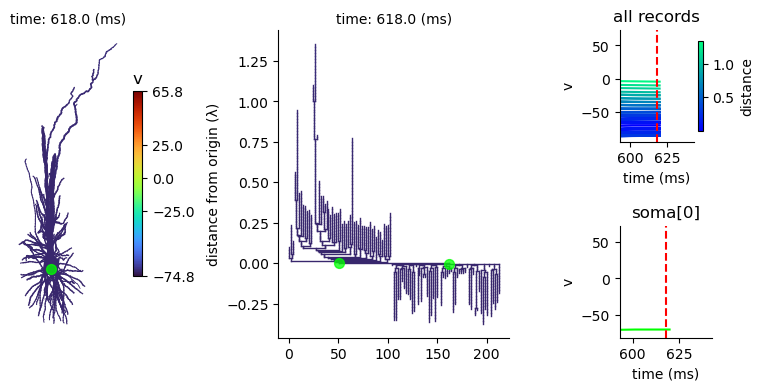

In [9]:
from matplotlib.gridspec import GridSpec
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
plt.tight_layout()
gs = GridSpec(2, 3, figure=fig, width_ratios=[1, 1, 0.4], hspace=0.75)
ax_morph = fig.add_subplot(gs[:, 0])
ax_dendogram = fig.add_subplot(gs[:, 1])
ax_soma_voltage = fig.add_subplot(gs[1, 2])
ax_tip_voltage = fig.add_subplot(gs[0, 2])
f = lambda: plt.subplots_adjust(wspace=0.6)
f()

seg_to_indicate_dict = dict()
seg_to_indicate_dict[list(analyser.cell.soma[0])[0]] = dict(label='soma', alpha=0.75, color='lime', size=50)
# seg_to_indicate_dict[list(analyser.cell.apic[96])[-1]] = dict(label='tip', alpha=0.75, color='grey', size=50)

start_seg = list(analyser.cell.soma[0])[0]
slow_down_factor=50
plot_kwargs=[dict(ax=ax_morph, seg = start_seg, 
                  records=records.all_records['v'], 
                  electrical=False, 
                  plot_type='morph', 
                  seg_to_indicate_dict=seg_to_indicate_dict,
                  plot_color_bar=True, 
                  theta=10,
                  diam_factor=1)]

plot_kwargs.append(dict(ax=ax_dendogram, 
                        seg = start_seg, 
                        records=records.all_records['v'], 
                        electrical=True, 
                        plot_type='dendogram', 
                        seg_to_indicate_dict=seg_to_indicate_dict,
                        plot_color_bar=False, ))

plot_kwargs.append(dict(ax=ax_soma_voltage, 
                        seg = start_seg, 
                        records=records.all_records['v'], 
                        plot_type='single_record', color='lime'))
                   

plot_kwargs.append(dict(ax=ax_tip_voltage, 
                        seg = start_seg, 
                        records=records.all_records['v'], 
                        distance_factor=50,
                        plot_every=0.1,
                        plot_type='all_records', 
                        color_distance=True, 
                        cmap=plt.cm.winter,
                        color_bar_kwarts=dict(shrink=0.8),
                       on_title=False, on_ylabel=True))


videos_folder = 'videos/passive_morph/'
video_name = 'spiking_morph_dendogram_and_voltage.mp4'
os.makedirs(videos_folder, exist_ok=True)
analyser.save_movie_from_rec(fig=fig, slow_down_factor=slow_down_factor, plot_kwargs=plot_kwargs,
                             func_before_run=[f], save_to=videos_folder, clip_name=video_name, fps=10, 
                             threads=16, preset='ultrafast')

video_player(Path.cwd(), videos_folder+video_name)